In [34]:
%matplotlib inline

In [1]:
import numpy as np

def complex_matrix(xmin, xmax, ymin, ymax, pixel_density):
    re = np.linspace(xmin, xmax, int((xmax - xmin) * pixel_density))
    im = np.linspace(ymin, ymax, int((ymax - ymin) * pixel_density))
    return re[np.newaxis, :] + im[:, np.newaxis] * 1j

In [2]:
np.linspace(0.1, 0.2, int((0.2 - 0.1) * 20))[:, None]

array([[0.1],
       [0.2]])

In [3]:
def is_stable(c, num_iterations):
    z = 0
    for _ in range(num_iterations):
        z = z ** 2 + c
    return abs(z) <= 2

In [4]:
vals = complex_matrix(0, 0.3, 0.5, 0.8, 20)
print(vals.shape)
vals

(6, 6)


array([[0.  +0.5j , 0.06+0.5j , 0.12+0.5j , 0.18+0.5j , 0.24+0.5j ,
        0.3 +0.5j ],
       [0.  +0.56j, 0.06+0.56j, 0.12+0.56j, 0.18+0.56j, 0.24+0.56j,
        0.3 +0.56j],
       [0.  +0.62j, 0.06+0.62j, 0.12+0.62j, 0.18+0.62j, 0.24+0.62j,
        0.3 +0.62j],
       [0.  +0.68j, 0.06+0.68j, 0.12+0.68j, 0.18+0.68j, 0.24+0.68j,
        0.3 +0.68j],
       [0.  +0.74j, 0.06+0.74j, 0.12+0.74j, 0.18+0.74j, 0.24+0.74j,
        0.3 +0.74j],
       [0.  +0.8j , 0.06+0.8j , 0.12+0.8j , 0.18+0.8j , 0.24+0.8j ,
        0.3 +0.8j ]])

In [5]:
import numpy as np

np.warnings.filterwarnings("ignore")
is_stable(vals, num_iterations=20)

array([[ True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True],
       [ True,  True,  True, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [6]:
def get_members(c, num_iterations):
    mask = is_stable(c, num_iterations)
    return c[mask]


In [7]:
m = get_members(vals, num_iterations=20)
m

array([0.  +0.5j , 0.06+0.5j , 0.12+0.5j , 0.18+0.5j , 0.24+0.5j ,
       0.3 +0.5j , 0.  +0.56j, 0.06+0.56j, 0.12+0.56j, 0.18+0.56j,
       0.24+0.56j, 0.3 +0.56j, 0.  +0.62j, 0.06+0.62j, 0.12+0.62j])

In [8]:
import matplotlib.pyplot as plt
import numpy as np

np.warnings.filterwarnings("ignore")

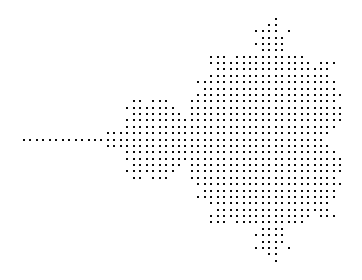

In [9]:
c = complex_matrix(-2, 0.5, -1.5, 1.5, pixel_density=21)
m = get_members(c, num_iterations=20)
plt.scatter(m.real, m.imag, color="black", marker=",", s=1)
plt.gca().set_aspect("equal")
plt.axis("off")
plt.tight_layout()
plt.show()

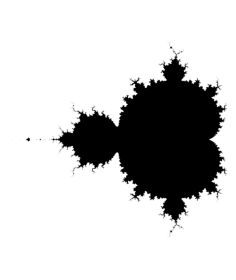

In [10]:
c = complex_matrix(-2, 0.5, -1.5, 1.5, pixel_density=512)
plt.imshow(is_stable(c, num_iterations=20), cmap="binary")
plt.gca().set_aspect("equal")
plt.axis("off")
plt.tight_layout()
plt.show()

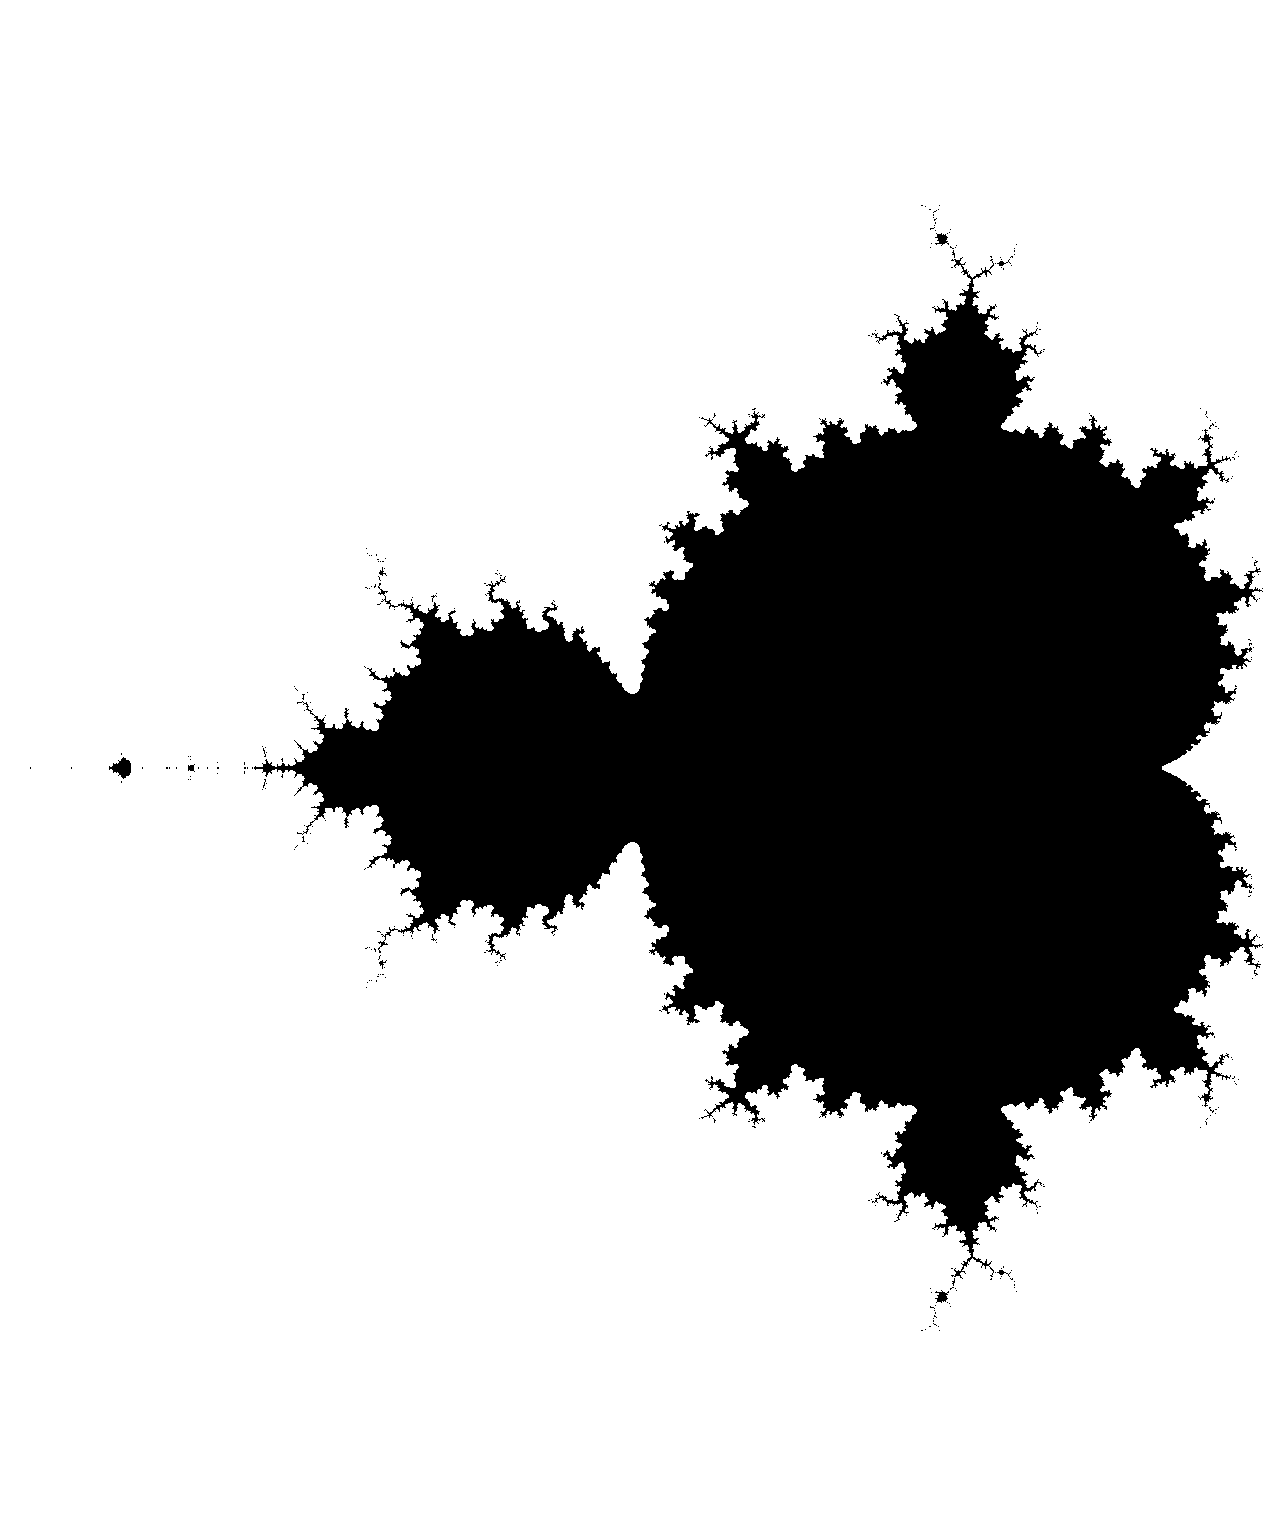

In [11]:
from PIL import Image
c = complex_matrix(-2, 0.5, -1.5, 1.5, pixel_density=512)
image = Image.fromarray(~is_stable(c, num_iterations=20))
image

In [12]:
image.size

(1280, 1536)

In [13]:
from dataclasses import dataclass

@dataclass
class MandelbrotSet:
    max_iterations: int

    def __contains__(self, c: complex) -> bool:
        return self.stability(c) == 1

    def stability(self, c: complex) -> float:
        return self.escape_count(c) / self.max_iterations

    def escape_count(self, c: complex) -> int:
        z = 0
        for iteration in range(self.max_iterations):
            z = z ** 2 + c
            if abs(z) > 2:
                return iteration
        return self.max_iterations

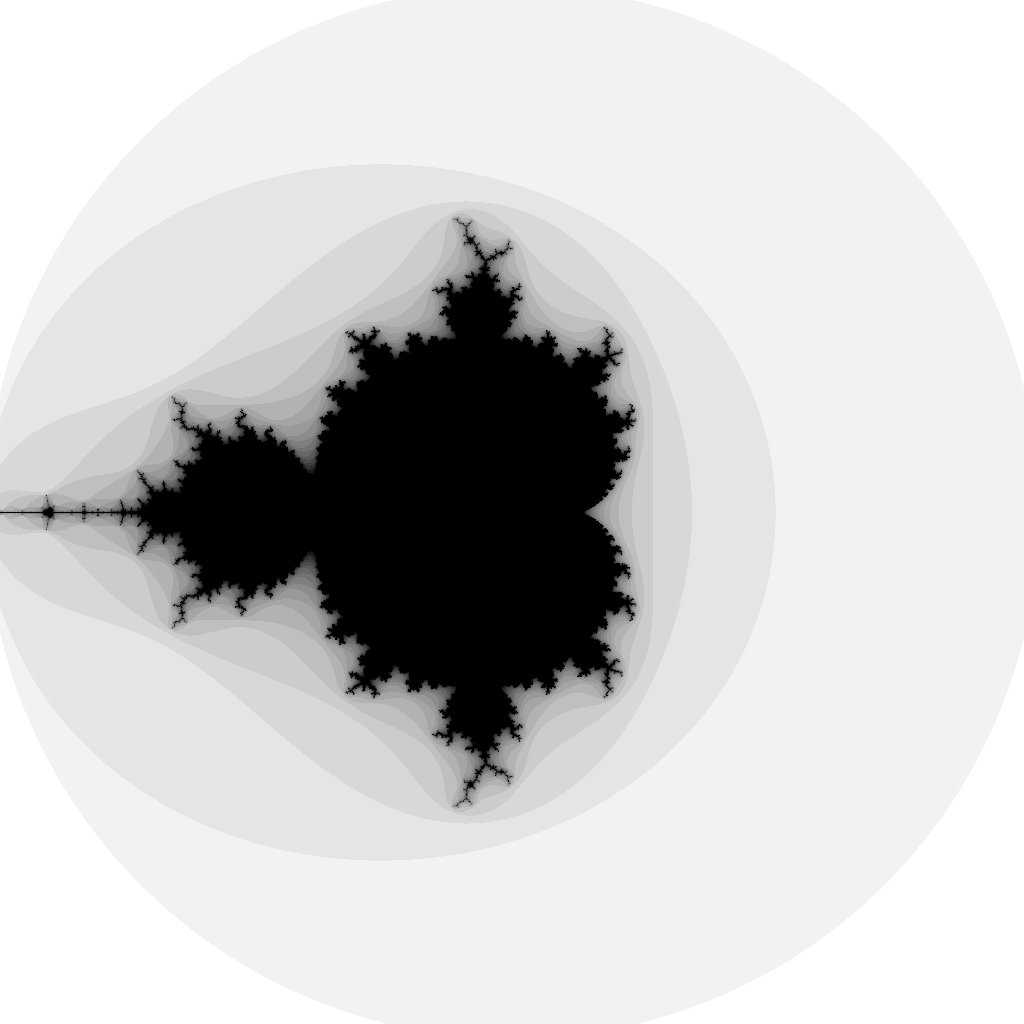

In [42]:
mandelbrot_set = MandelbrotSet(max_iterations=20)

width, height = 1024, 1024
scale = 0.0038
GRAYSCALE = "L"

from PIL import Image
image = Image.new(mode=GRAYSCALE, size=(width, height))
for y in range(height):
    for x in range(width):
        c = scale * complex(x - width / 2, height / 2 - y)
        instability = 1 - mandelbrot_set.stability(c)
        image.putpixel((x, y), int(instability * 255))

image

In [15]:
from math import log

def escape_count(c: complex, smooth=False, max_iterations: int = 20, escape_radius=2.0):
        z = 0
        for iteration in range(max_iterations):
            z = z ** 2 + c
            if abs(z) > escape_radius:
                if smooth:
                    return iteration + 1 - log(log(abs(z))) / log(2)
                return iteration
        return max_iterations

In [16]:
escape_count(c=0.26, smooth=False, max_iterations=50)

29

In [17]:
escape_count(c=0.26, smooth=True, max_iterations=50)


29.529059720873665

In [18]:
from dataclasses import dataclass
from PIL import Image

@dataclass
class Viewport:
    image: Image.Image
    center: complex
    width: float

    @property
    def height(self):
        return self.scale * self.image.height

    @property
    def offset(self):
        return self.center + complex(-self.width, self.height) / 2

    @property
    def scale(self):
        return self.width / self.image.width

    def __iter__(self):
        for y in range(self.image.height):
            for x in range(self.image.width):
                yield Pixel(self, x, y)

In [19]:
from dataclasses import dataclass
from math import log

@dataclass
class MandelbrotSet:
    max_iterations: int
    escape_radius: float = 2.0

    def __contains__(self, c: complex) -> bool:
        return self.stability(c) == 1

    def stability(self, c: complex, smooth=False, clamp=True) -> float:
        value = self.escape_count(c, smooth) / self.max_iterations
        return max(0.0, min(value, 1.0)) if clamp else value

    def escape_count(self, c: complex, smooth=False) -> int | float:
        z = 0
        for iteration in range(self.max_iterations):
            z = z ** 2 + c
            if abs(z) > self.escape_radius:
                if smooth:
                    return iteration + 1 - log(log(abs(z))) / log(2)
                return iteration
        return self.max_iterations

In [20]:
@dataclass
class Pixel:
    viewport: Viewport
    x: int
    y: int

    @property
    def color(self):
        return self.viewport.image.getpixel((self.x, self.y))

    @color.setter
    def color(self, value):
        self.viewport.image.putpixel((self.x, self.y), value)

    def __complex__(self):
        return (
                complex(self.x, -self.y)
                * self.viewport.scale
                + self.viewport.offset
        )

In [119]:
mandelbrot_set.stability(1 + 1j)

0.2

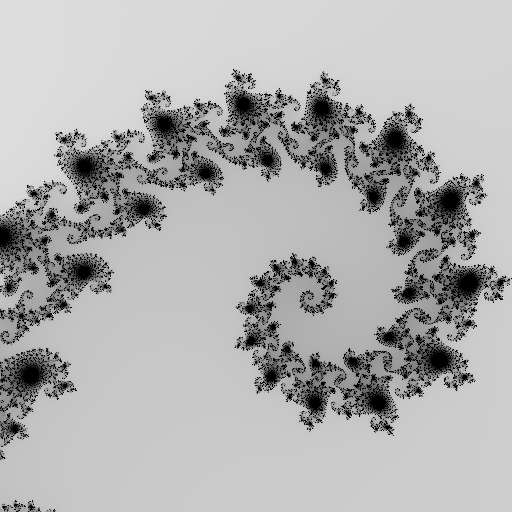

In [43]:
from PIL import Image

mandelbrot_set = MandelbrotSet(max_iterations=256, escape_radius=1000)

image = Image.new(mode="L", size=(512, 512))
for pixel in Viewport(image, center=-0.7435 + 0.1314j, width=0.002):
    c = complex(pixel)
    instability = 1 - mandelbrot_set.stability(c, smooth=True)
    pixel.color = int(instability * 255)

image

In [28]:
import numpy as np
from scipy.interpolate import interp1d

def make_gradient(colors, interpolation="linear"):
    X = [i / (len(colors) - 1) for i in range(len(colors))]
    Y = [[color[i] for color in colors] for i in range(3)]
    channels = [interp1d(X, y, kind=interpolation) for y in Y]
    return lambda x: [np.clip(channel(x), 0, 1) for channel in channels]

In [22]:
def denormalize(palette):
    return [
        tuple(int(channel * 255) for channel in color)
        for color in palette
    ]

In [98]:
from PIL.ImageColor import getrgb

def hsb(hue_degrees: int, saturation: float, brightness: float):
    return getrgb(
        f"hsv({hue_degrees % 360},"
        f"{saturation * 100:.8f}%,"
        f"{brightness * 100}%)"
    )

hsb(360, 0.75, 1)

(255, 64, 64)

In [49]:
# mandelbrot_set = MandelbrotSet(max_iterations=512, escape_radius=1000)
image = Image.new(mode="RGB", size=(512, 512))
viewport = Viewport(image, center=-0.7435 + 0.1314j, width=0.002)
# paint(mandelbrot_set, viewport, palette, smooth=True)
# image.show()

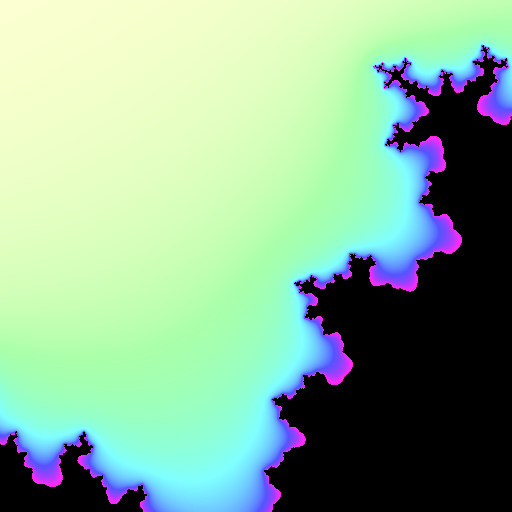

In [53]:
mandelbrot_set = MandelbrotSet(max_iterations=20, escape_radius=1000)
for pixel in Viewport(image, center=-0.75 + 0.5j, width=0.5):
    stability = mandelbrot_set.stability(complex(pixel), smooth=True)
    pixel.color = (0, 0, 0) if stability == 1 else hsb(
        hue_degrees=int(stability * 360),
        saturation=stability,
        brightness=1,
    )

image

In [116]:
c = complex_matrix(-2, 0.5, -1.5, 1.5, pixel_density=512)
# image = Image.fromarray(~is_stable(c, num_iterations=20))
# image
c.shape

(1536, 1280)

In [100]:
from matplotlib.colors import hsv_to_rgb

In [138]:
def stability_to_color(s):
    return hsv_to_rgb(np.stack([s, s, np.where(s<1.0, 1, 0)]).transpose(1, 2, 0))

TypeError: Image data of dtype complex128 cannot be converted to float

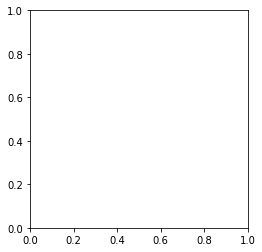

In [117]:
# n = 1000000
# d = np.arange(0, 1, 1/n).reshape(int(np.sqrt(n)), int(np.sqrt(n)))
# print(d.shape)

rgb_vals = stability_to_color(c)
plt.imshow(rgb_vals)

In [194]:
np.log(-1+-3j)

(1.151292546497023-1.892546881191539j)

In [197]:
np.log(2.7)

0.9932517730102834

In [201]:
def matrix_stability(c, max_iterations: int = 20, escape_radius: float = 5, smooth: bool = False, debug: bool = False):
    stability = np.zeros_like(c).astype(float)
    z = np.zeros_like(c).astype(float)
    for iteration in range(max_iterations):
        z = z ** 2 + c
        if smooth:
            new_stability = np.where(np.abs(z) > escape_radius, iteration + 1 - np.log(np.log(np.abs(z))) / np.log(2), 0)
            where_zero = np.where(stability == 0, 1, 0)
            update = new_stability * where_zero
            update = np.where(np.isnan(update), 0, update)
            if debug:
                print('new stability')
                print(new_stability)
                print('new zero')
                print(where_zero)
                print('update')
                print(update)
            stability += update
        else:
            new_stability = np.where(np.abs(z) > escape_radius, iteration , 0)
            where_zero = np.where(stability == 0, 1, 0)
            update = new_stability * where_zero
            if debug:
                print('new stability')
                print(new_stability)
                print('new zero')
                print(where_zero)
                print('update')
                print(update)
            stability += update

    scaled_stability = stability / max_iterations
    return 1 - scaled_stability
    return np.where(scaled_stability == 0, 1, scaled_stability)

s = matrix_stability(c, max_iterations=40, escape_radius=100, smooth=True, debug=True)
s

new stability
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
new zero
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
update
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
new stability
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
new zero
[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]
update
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
new stability
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. .

array([[0.96593741, 0.96591225, 0.96588709, ..., 0.95473894, 0.95477809,
        0.95481723],
       [0.96590703, 0.96588183, 0.96585661, ..., 0.95467773, 0.95471703,
        0.95475632],
       [0.96587662, 0.96585136, 0.9658261 , ..., 0.95461639, 0.95465584,
        0.95469528],
       ...,
       [0.96587662, 0.96585136, 0.9658261 , ..., 0.95461639, 0.95465584,
        0.95469528],
       [0.96590703, 0.96588183, 0.96585661, ..., 0.95467773, 0.95471703,
        0.95475632],
       [0.96593741, 0.96591225, 0.96588709, ..., 0.95473894, 0.95477809,
        0.95481723]])

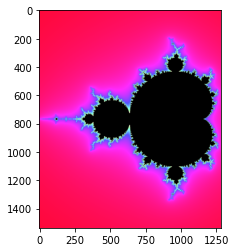

In [202]:
plt.imshow(stability_to_color(s))

In [204]:
Image.fromarray((stability_to_color(s)*255).astype(int))

TypeError: Cannot handle this data type: (1, 1, 3), <i8